## Train SEVIRI baseline retrieval

In [1]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
data_path = Path(os.environ["TRAINING_DATA"])

KeyError: 'TRAINING_DATA'

In [3]:
try:
    data_path = Path(os.environ["TRAINING_DATA"])
except KeyError:
    data_path = "/home/simonpf/data_3/cimr/training_data/"

<AxesSubplot:>

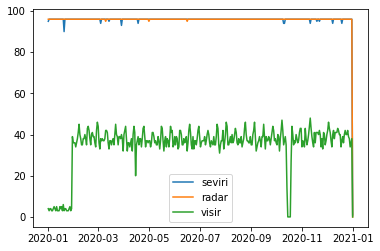

In [4]:
from cimr.data.training_data import plot_date_distribution
plot_date_distribution(data_path, ["seviri", "radar", "visir"])#"mw"])

In [5]:
from cimr.data.training_data import CIMRDataset, CIMRSequenceDataset
from torch.utils.data import DataLoader

start_time = np.datetime64("2020-05-01T00:00:00")
end_time = np.datetime64("2020-06-28T00:00:00")
training_data = CIMRDataset(data_path,
                            start_time=start_time,
                            end_time=end_time,
                            window_size=256,
                            sequence_length=1,
                            sample_rate=1)
training_loader = DataLoader(training_data, num_workers=8, batch_size=8, shuffle=True)

start_time = np.datetime64("2020-06-28T00:00:00")
end_time = np.datetime64("2020-07-01T00:00:00")
validation_data = CIMRDataset(data_path,
                              start_time=start_time,
                              end_time=end_time,
                              window_size=512,
                              sequence_length=1)
validation_loader = DataLoader(validation_data, num_workers=4, batch_size=16, shuffle=True)

In [6]:
from cimr.models import CIMRSeviri, CIMRSeqSeviri, CIMR
model = CIMR(n_stages=4, n_features=32, n_outputs=64)

In [ ]:
x, y

In [8]:
import torch
from cimr.models import CIMRSmol
from quantnn.qrnn import QRNN

quantiles = np.linspace(0, 1, 66)[1:-1]
qrnn = QRNN(quantiles=quantiles, model=model)

In [9]:
n_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=n_epochs
)
qrnn.train(
    training_data=training_loader,
    validation_data=validation_loader,
    n_epochs=n_epochs,
    device="cpu",
    mask=-100,
    optimizer=optimizer,
    scheduler=scheduler
)
qrnn.save(cimr_path / models / "cimr_seviri.pckl")

Output()

                                                          
                                                          
                     Training history                     
                                                          
                                                          
       Epoch         Training loss      Validation loss   
 ──────────────────────────────────────────────────────── 
     #      LR           Total               Total        
                                                          
      1   0.0005         3.354               3.447

KeyboardInterrupt: 

In [20]:
it = iter(training_loader)
x, y = next(it)

/home/simonpf/miniconda3/envs/cimr/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
/usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/simonpf/miniconda3/envs/cimr/lib/python3.8/site-packages/rasterio/../../.././libtiledb.so.2.8)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/simonpf/miniconda3/envs/cimr/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
/usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/simonpf/miniconda3/envs/cimr/lib/python3.8/site-packages/rasterio/../../.././libtiledb.so.2.8)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/simonpf/miniconda3/envs/cimr/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
/usr/lib/x86_64-linux-gnu/libstdc++.so

In [44]:
y = model(x)

UpsamplingStage(
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (block): Sequential(
    (0): Conv2d(1152, 384, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvNextBlock(
      (body): Sequential(
        (0): SymmetricPadding()
        (1): SeparableConv(
          (0): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), groups=384)
          (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(384, 768, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): GELU(approximate=none)
        (3): Conv2d(768, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (projection): Identity()
    )
  )
) torch.Size([8, 768, 16, 16]) torch.Size([8, 384, 32, 32])
UpsamplingStage(
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (block): Sequential(
    (0): Conv2d(576, 192, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvNextBlock(
      (body): Sequential(
        (0): SymmetricPadding()
        (1): SeparableConv(
   

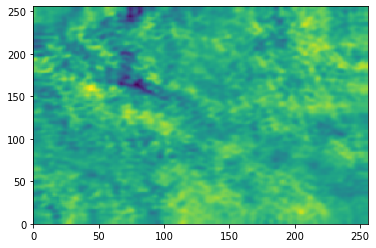

In [61]:
plt.pcolormesh(y.detach().numpy()[0, 14])

In [39]:
qrnn.model.down_stages[-1]

DownsamplingStage(
  (0): DownsamplingBlock(
    (0): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(288, 384, kernel_size=(2, 2), stride=(2, 2))
  )
  (1): ConvNextBlock(
    (body): Sequential(
      (0): SymmetricPadding()
      (1): SeparableConv(
        (0): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), groups=384)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(384, 768, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): GELU(approximate=none)
      (3): Conv2d(768, 384, kernel_size=(1, 1), stride=(1, 1))
    )
    (projection): Identity()
  )
  (2): ConvNextBlock(
    (body): Sequential(
      (0): SymmetricPadding()
      (1): SeparableConv(
        (0): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), groups=384)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(384, 768, kernel_size=(1,

In [40]:
qrnn.model.up_stages[0]

UpsamplingStage(
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (block): Sequential(
    (0): Conv2d(1152, 384, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvNextBlock(
      (body): Sequential(
        (0): SymmetricPadding()
        (1): SeparableConv(
          (0): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), groups=384)
          (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(384, 768, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): GELU(approximate=none)
        (3): Conv2d(768, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (projection): Identity()
    )
  )
)

In [33]:
len(qrnn.model.up_stages)

4

In [11]:
from quantnn.qrnn import QRNN
qrnn = QRNN.load("../models/cimr_baseline_4_4_128.pckl")
qrnn.model.train(False)
model = qrnn.model

In [12]:
validation_iterator = iter(validation_loader)

In [13]:
x, y = next(validation_iterator)

In [14]:
quantiles = np.linspace(0, 1.0, 66)[1:-1]

In [15]:
import torch
from quantnn.quantiles import posterior_mean
model = qrnn.model
model.to("cpu")

# Sequence data
with torch.no_grad():
    y_pred = posterior_mean(y_pred=model(x), quantile_axis=1, quantiles=torch.tensor(quantiles))

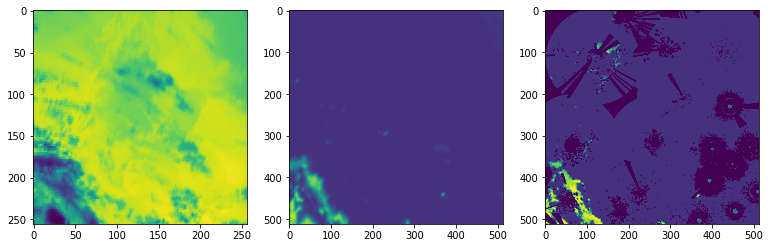

In [25]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

ind = 8

ax = axs[0]
m = ax.imshow(x["geo"][ind, -2])

ax = axs[1]
m = ax.imshow(y_pred[ind], vmin=-40, vmax=30)

ax = axs[2]
m = ax.imshow(y[ind], vmin=-40, vmax=30)